In [1]:
import sys
sys.path.insert(0, 'C:/Users/user/iplab/stock_factor_lab')

In [2]:
from database import Database
from get_data import Data
import backtest
from combinations import sim_conditions
from quantile_regression import QuantileRegressionModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data=Data()

# Step 1
準備好每個因子，不同群樹對應的CAGR
這邊我只用兩個因子來作範例

In [4]:
factor_2001_2008={
    'eps': data.get('report:eps').loc["2001":"2008-08"].divide_slice(quantile=100, ascending = False), # 大到小
    'pe': data.get('report:pe').loc["2001":"2008-08"].divide_slice(quantile=100, ascending = True), # 小到大
}

In [5]:
factor_perfor_2001 = pd.DataFrame()

for factor in factor_2001_2008:
    single_factor_report_collection = sim_conditions(conditions=factor_2001_2008[factor], resample="M", data=data, combination=False)
    factor_perfor_2001.index = single_factor_report_collection.stats.transpose().index
    factor_perfor_2001[str(factor)] = single_factor_report_collection.stats.transpose()['CAGR']

Backtesting progress: 100%|██████████| 100/100 [01:29<00:00,  1.12condition/s]


In [6]:
factor_perfor_2001 = factor_perfor_2001 * 100
factor_perfor_2001["Quantile_Num"] = range(1, 101)

In [7]:
factor_2009_2023={
    'eps': data.get('report:eps').loc["2008-10":].divide_slice(quantile=100, ascending = False), # 大到小
    'pe': data.get('report:pe').loc["2008-10":].divide_slice(quantile=100, ascending = True), # 小到大
}

In [8]:
factor_perfor_2009 = pd.DataFrame()

for factor in factor_2009_2023:
    single_factor_report_collection = sim_conditions(conditions=factor_2009_2023[factor], resample="M", data=data, combination=False)
    factor_perfor_2009.index = single_factor_report_collection.stats.transpose().index
    factor_perfor_2009[str(factor)] = single_factor_report_collection.stats.transpose()['CAGR']

Backtesting progress: 100%|██████████| 100/100 [01:26<00:00,  1.15condition/s]


In [9]:
factor_perfor_2009 = factor_perfor_2009 * 100
factor_perfor_2009["Quantile_Num"] = range(1, 101)

In [10]:
factor_perfor_2001['period'] = '2001-2008'
factor_perfor_2009['period'] = '2009-2023'
factor_res = pd.concat([factor_perfor_2001, factor_perfor_2009], ignore_index=True)
factor_res

,eps,pe,Quantile_Num,period
0,12.046010,0.000000,1,2001-2008
1,11.563165,0.000000,2,2001-2008
2,4.424408,0.000000,3,2001-2008
3,13.324891,0.000000,4,2001-2008
4,6.429908,0.000000,5,2001-2008
...,...,...,...,...
195,8.966546,14.410548,96,2009-2023
196,8.787688,15.586942,97,2009-2023
197,6.766531,19.780330,98,2009-2023
198,11.463672,15.281246,99,2009-2023


# Step 2
分位數回歸分析，可以用formula設定你想要的x、y

In [12]:
from quantile_regression import QuantileRegressionModel
quantiles = np.round(np.arange(0.1, 1, 0.1), decimals=1).tolist()
quantiles.insert(0, 0.05)  # 在列表開頭插入0.05
quantiles.append(0.95) 

formula_template = "{factor} ~ Quantile_Num"

model = QuantileRegressionModel(factor_res, quantiles, factor_2001_2008.keys(), formula_template)

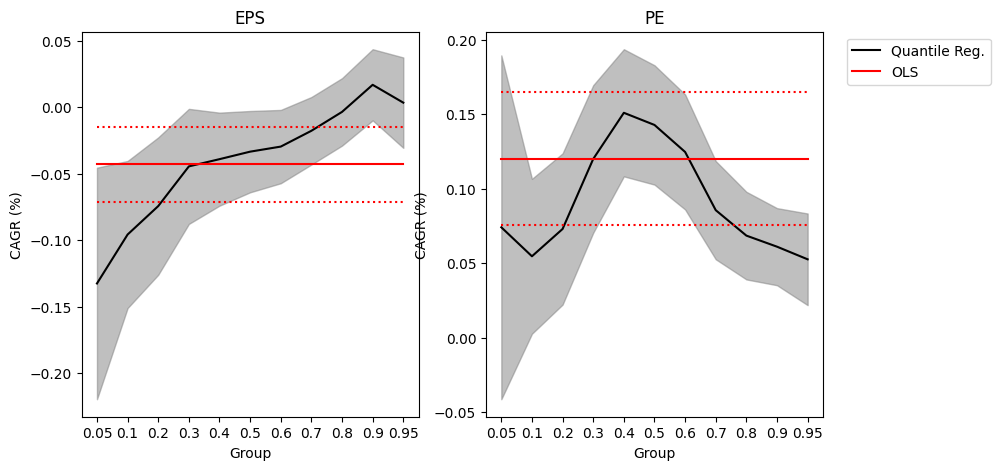

In [13]:
model.plot_results(mode='line')

In [14]:
reg_result_df, reg_pvalues_df = model.get_coefficients_and_pvalues(ols= True)
reg_result_df

,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,ols
eps,-0.132580,-0.095754,-0.074361,-0.044499,-0.039058,-0.033409,-0.029594,-0.017703,-0.003491,0.016896,0.003461,-0.042972
pe,0.074007,0.054554,0.072882,0.119884,0.150889,0.142728,0.124592,0.085506,0.068429,0.060996,0.052515,0.119923


In [15]:
reg_pvalues_df

,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,ols
eps,0.003028,0.000780,0.005024,0.043984,2.890844e-02,3.245944e-02,3.557249e-02,1.709955e-01,0.786355,0.214707,0.841125,3.281408e-03
pe,0.207547,0.039817,0.005110,0.000004,4.545209e-11,3.335341e-11,1.339339e-09,7.379513e-07,0.000008,0.000006,0.000913,3.213856e-07


# Step 3
- 利用QR的影響係數、截距項建構數學式子，預測未來CAGR

In [16]:
factor_config = {
    'eps': False,
    'pe': True,
}


In [17]:
target_factor_list = ['eps', 'pe']
target_factor_dict = {}

# Loop through each factor, retrieve the data, and apply the divide_slice function
for factor, asc in factor_config.items():
    df = data.get(f'report:{factor}')
    target_factor_dict[f'{factor}'] = df.rank(ascending=asc, axis=1)

In [18]:
# 這邊可以從圖片或是reg_reslut_df觀察絕對值後最大的分位數
good_quantile={
    'eps' :  model.models['eps']['0.05'].params["Intercept"] + target_factor_dict['eps'] * model.models['eps']['0.05'].params["Quantile_Num"],
    'pe' :  model.models['pe']['0.4'].params["Intercept"] + target_factor_dict['pe'] * model.models['pe']['0.4'].params["Quantile_Num"],
}


# Step 4
根據預測出來的CAGR切割成10群，買入持有第一群

In [19]:
for key, df in target_factor_dict.items():
    good_quantile[key] = good_quantile[key].divide_slice(quantile=10, ascending = False)['Quantile_1']


In [20]:
print("平均:",good_quantile['pe'].sum(axis=1).mean())
print("中位數:",good_quantile['pe'].sum(axis=1).quantile(0.5))

平均: 140.50526315789475
中位數: 137.0


In [21]:
target_factor_report_collection = sim_conditions(good_quantile, resample="M", data=data)
target_factor_report_collection.plot_stats(mode='heatmap')

Backtesting progress: 100%|██████████| 2/2 [00:11<00:00,  5.98s/condition]


,CAGR,daily_sharpe,max_drawdown,avg_drawdown,win_ratio,ytd
eps,0.091490,28.000000,-0.506639,-0.075696,0.376041,0.369214
pe,0.084886,20.980000,-0.675069,-0.185728,0.456964,0.266755


# 繪圖

In [22]:
factor_best_quantile = {
    'eps': '0.05',
    'pe': '0.4'
}


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data from the provided table
data = {
    f : {
        'Coef' : abs(model.models[f][q].params['Quantile_Num']),
        'CAGR' : target_factor_report_collection.stats[f]['CAGR']*100,
        'MDD' : target_factor_report_collection.stats[f]['max_drawdown']*100
    } for f, q in factor_best_quantile.items()
}
df = pd.DataFrame(data).T
df = df.reset_index(names=['Factor'])

# df = df.set_index('Factor')
df

,Factor,Coef,CAGR,MDD
0,eps,0.132580,9.148974,-50.66388
1,pe,0.150889,8.488632,-67.50685


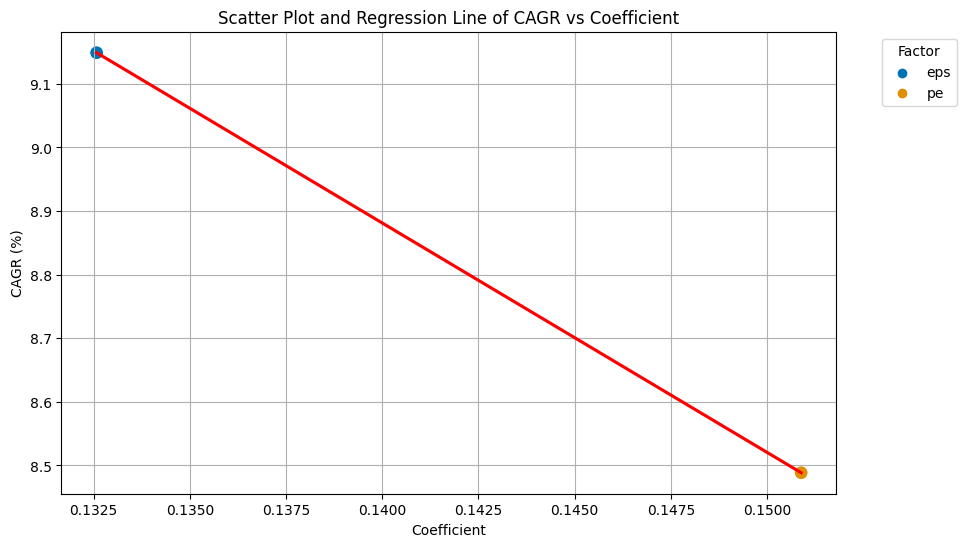

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already defined with 'Coefficient', 'CAGR', and 'Factor' columns

# Plotting
plt.figure(figsize=(10, 6))
# First, plot the scatter points and use labels
sns.scatterplot(data=df, x='Coef', y='CAGR', hue='Factor', palette='colorblind', s=100)

# Now, add the regression line without adding a legend entry for it
sns.regplot(data=df, x='Coef', y='CAGR', scatter=False, ci=None, color='red')

# Add labels and title
plt.xlabel('Coefficient')
plt.ylabel('CAGR (%)')
plt.title('Scatter Plot and Regression Line of CAGR vs Coefficient')

# Show the plot with a grid and move the legend outside
plt.grid(True)
plt.legend(title='Factor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


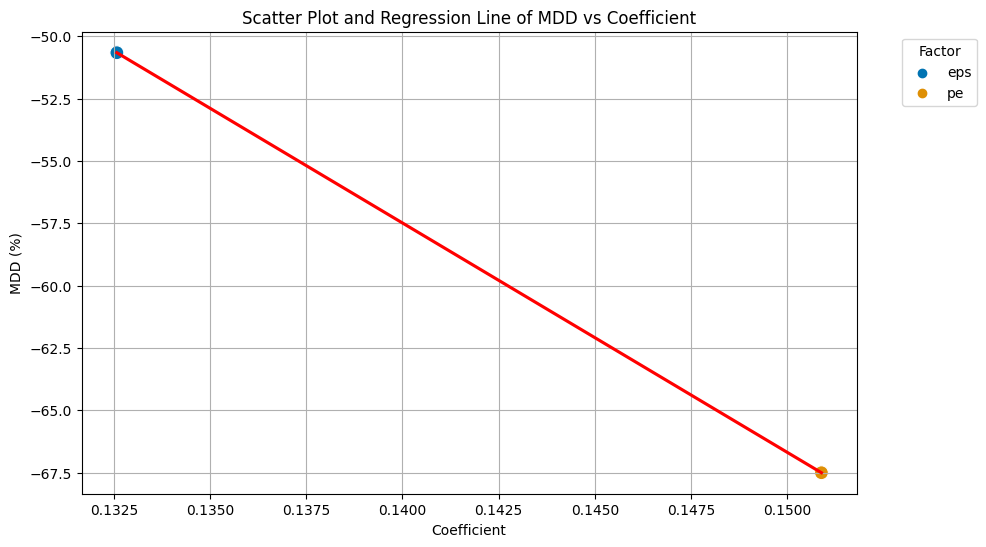

In [25]:
import seaborn as sns

# 繪製散佈圖
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Coef', y='MDD', hue='Factor', palette='colorblind',s=100)


sns.regplot(data=df, x='Coef', y='MDD', scatter=False, ci=None, color='red')

# Add labels and title
plt.xlabel('Coefficient')
plt.ylabel('MDD (%)')
plt.title('Scatter Plot and Regression Line of MDD vs Coefficient')


# 顯示圖形
plt.grid(True)
plt.legend(title='Factor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
